In [6]:
#@title Install dependencies

!pip install -q torchaudio omegaconf transformers

import torch
from pprint import pprint
from omegaconf import OmegaConf
from IPython.display import Audio, display

torch.hub.download_url_to_file('https://raw.githubusercontent.com/snakers4/silero-models/master/models.yml',
                               'latest_silero_models.yml',
                               progress=False)
models = OmegaConf.load('latest_silero_models.yml')

In [7]:
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F


FINAL_LENGTH = 24_000

def prepare_audio(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    resampler = T.Resample(sample_rate, 16000)
    
        
    waveform = torch.mean(waveform, axis=0)
    audio = resampler(waveform)
    padding_length = max(0, FINAL_LENGTH - audio.size(0))
    #padded_audio = F.pad(audio, (0, padding_length))

    transform_spec = T.MelSpectrogram(16000, pad=padding_length)
    melspec = transform_spec(padded_audio[:FINAL_LENGTH])
    return melspec

In [12]:
!pip install librosa

from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


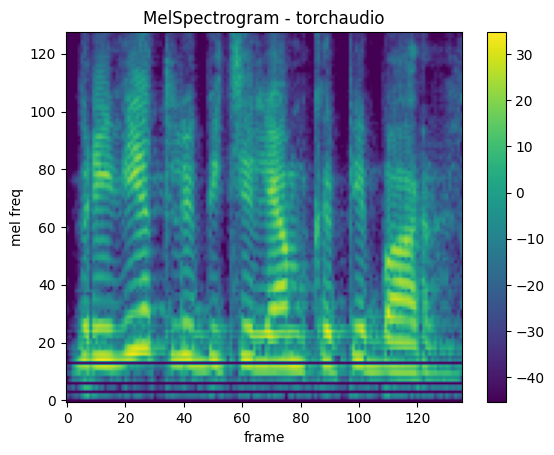

In [13]:
plot_spectrogram(prepare_audio("dataset/audio/0.wav"), title="MelSpectrogram - torchaudio", ylabel="mel freq")

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Define your custom dataset class
class AudioTensorDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        audio_path, tensor = self.df.iloc[idx]
        audio = prepare_audio(audio_path)
        tensor = torch.Tensor(np.fromstring(tensor.replace('[', '').replace(']', ''), sep=' '))
        return audio, tensor

In [3]:
import pandas as pd

In [4]:
dataset_df = pd.read_csv("silero_dataset.csv")
dataset_df = dataset_df.drop(dataset_df.columns[[0, 1]], axis=1)

In [5]:
batch_size = 32
num_epochs = 10
learning_rate = 0.0001

In [6]:
from tqdm.notebook import tqdm

In [7]:
# Define the Hubert model
from transformers import Wav2Vec2FeatureExtractor
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        # self.lin1 = nn.Linear(48000, 24000)
        # self.rel1 = nn.LeakyReLU()
        self.lin2 = nn.Linear(24000, 8_000)
        self.rel2 = nn.LeakyReLU()
        self.lin3 = nn.Linear(8_000, 4_000)
        self.rel3 = nn.LeakyReLU()
        self.lin4 = nn.Linear(4_000, 1_000)
        self.rel4 = nn.LeakyReLU()
        self.lin5 = nn.Linear(1000, 256)

    def forward(self, x):
        #x = self.feature_extractor(x, return_tensors="pt", sampling_rate=16000)["input_values"][0].to('cuda')  # Extract features from the audio
        #print("Shape", x.shape)
        # x = self.lin1(x)
        # x = self.rel1(x)

        x = self.lin2(x)
        x = self.rel2(x)

        x = self.lin3(x)
        x = self.rel3(x)

        x = self.lin4(x)
        x = self.rel4(x)

        x = self.lin5(x)
        #output_pooled = self.pooling(output.transpose(1, 2)).transpose(1, 2)
        return x


In [8]:
def pad_tensor(vec, pad, dim):
    """
    args:
        vec - tensor to pad
        pad - the size to pad to
        dim - dimension to pad

    return:
        a new tensor padded to 'pad' in dimension 'dim'
    """
    pad_size = list(vec.shape)
    pad_size[dim] = pad - vec.size(dim)
    return torch.cat([vec, torch.zeros(*pad_size)], dim=dim)[:, :MIN_LENGTH]

class PadCollate:
    """
    a variant of callate_fn that pads according to the longest sequence in
    a batch of sequences
    """

    def __init__(self, dim=0):
        """
        args:
            dim - the dimension to be padded (dimension of time in sequences)
        """
        self.dim = dim

    def pad_collate(self, batch):
        """
        args:
            batch - list of (tensor, label)

        reutrn:
            xs - a tensor of all examples in 'batch' after padding
            ys - a LongTensor of all labels in batch
        """
        # find longest sequence
        max_len = max(map(lambda x: x[0].shape[self.dim], batch))
        # pad
        #print([x[0].shape for x in batch])
        data = [pad_tensor(x[0], pad=max_len, dim=self.dim) for x in batch]
        # stack all
        xs = torch.stack(data, dim=0)
        #print("Shape in collator", xs.shape)
        ys = torch.stack([y[1] for y in batch], dim=0)
        return xs, ys

    def __call__(self, batch):
        return self.pad_collate(batch)

collator = PadCollate(dim=1)

In [9]:
dataset = AudioTensorDataset(dataset_df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:


# Initialize HuBERT model


# Initializing a model from the facebook/hubert-base-ls960 style configuration
model = CustomModel()
# model = HubertModel.from_pretrained("facebook/hubert-base-ls960")
#model.encoder.layers[11].final_layer_norm = nn.Linear(768, 256)

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for epoch in range(num_epochs):
    i = 0
    for (audio, tensor) in tqdm(dataloader):
        audio = audio.to(device).squeeze(dim=1)
        tensor = tensor.to(device).squeeze(dim=1)
        # print(audio)
        # print(audio.shape)
        #print(tensor.shape)

        # Forward pass
        output = model(audio)
        # print(output)
        #print(output.shape)
        # print(output.size())
        # Compute loss
        loss = loss_function(output, tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print progress
        if i % 1000 == 0:
            print(f"{i} Loss: {loss.item():.4f}")
        i += 1
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
    torch.save(model.state_dict(), f"{epoch}_state_dict.pt")


  0%|          | 0/3126 [00:00<?, ?it/s]

0 Loss: 1.0017
1000 Loss: 0.9836
2000 Loss: 1.0182
3000 Loss: 1.0187
Epoch 1/10, Loss: 1.1309


  0%|          | 0/3126 [00:00<?, ?it/s]

0 Loss: 0.9900
1000 Loss: 0.9821
2000 Loss: 0.9603
3000 Loss: 0.9768
Epoch 2/10, Loss: 1.0161


  0%|          | 0/3126 [00:00<?, ?it/s]

0 Loss: 0.9673
1000 Loss: 0.9702
2000 Loss: 1.0297
3000 Loss: 0.9680
Epoch 3/10, Loss: 1.1918


  0%|          | 0/3126 [00:00<?, ?it/s]

0 Loss: 0.9996


In [21]:
import gc
torch.cuda.empty_cache()
gc.collect()

1757

In [ ]:
torch.save(model.state_dict(), "custom_model_state_dict.pt")
torch.save(model, "custom_model.pt")

In [ ]:
print(model)

CustomModel(
  (lin1): Linear(in_features=10000, out_features=5000, bias=True)
  (rel1): LeakyReLU(negative_slope=0.01)
  (lin2): Linear(in_features=5000, out_features=2500, bias=True)
  (rel2): LeakyReLU(negative_slope=0.01)
  (lin3): Linear(in_features=2500, out_features=1250, bias=True)
  (rel3): LeakyReLU(negative_slope=0.01)
  (lin4): Linear(in_features=1250, out_features=625, bias=True)
  (rel4): LeakyReLU(negative_slope=0.01)
  (lin5): Linear(in_features=625, out_features=256, bias=True)
)


In [ ]:
def pad_collate(batch):
        """
        args:
            batch - list of (tensor, label)

        reutrn:
            xs - a tensor of all examples in 'batch' after padding
            ys - a LongTensor of all labels in batch
        """
        # find longest sequence
        max_len = max(map(lambda x: x.shape[1], batch))
        # pad
        #print([x[0].shape for x in batch])
        data = [pad_tensor(x, pad=max_len, dim=1) for x in batch]
        # stack all
        xs = torch.stack(data, dim=0)
        return xs

In [ ]:
torch.save(torch.tensor_split(model(pad_collate([torchaudio.load("y2Zl48KPTM8short.mp3")[0]]))[0], 2, dim=1)[0], "speaker.pt")

In [ ]:
torch.tensor_split(model(pad_collate([torchaudio.load("y2Zl48KPTM8short.mp3")[0]]))[0], 2, dim=1)[0]

torch.Size([2, 128])

In [ ]:
(torch.split(pad_collate([torchaudio.load("y2Zl48KPTM8short.mp3")[0]]), 2))

(tensor([[[ 0.0068,  0.0108,  0.0167,  ..., -0.2071, -0.2432, -0.2742],
          [ 0.0068,  0.0108,  0.0167,  ..., -0.2071, -0.2432, -0.2742]]]),)

In [14]:
from IPython.display import FileLink
FileLink("2_state_dict.pt")

/root/2_state_dict.pt

In [ ]:
waveform, sample_rate = torchaudio.load("dataset/audio/0.wav")
audio = resampler(waveform)

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding=True,  do_normalize=True, return_attention_mask=False)

In [ ]:
feature_extractor(audio, sampling_rate=16000)["input_values"][0].shape

(1, 22600)